# plot each lidar snow, summed sd, r2

/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Mores.sd.nc


ValueError: replacement data must match the Variable's shape. replacement data has shape (2735, 3504); Variable has shape (1383, 1796)

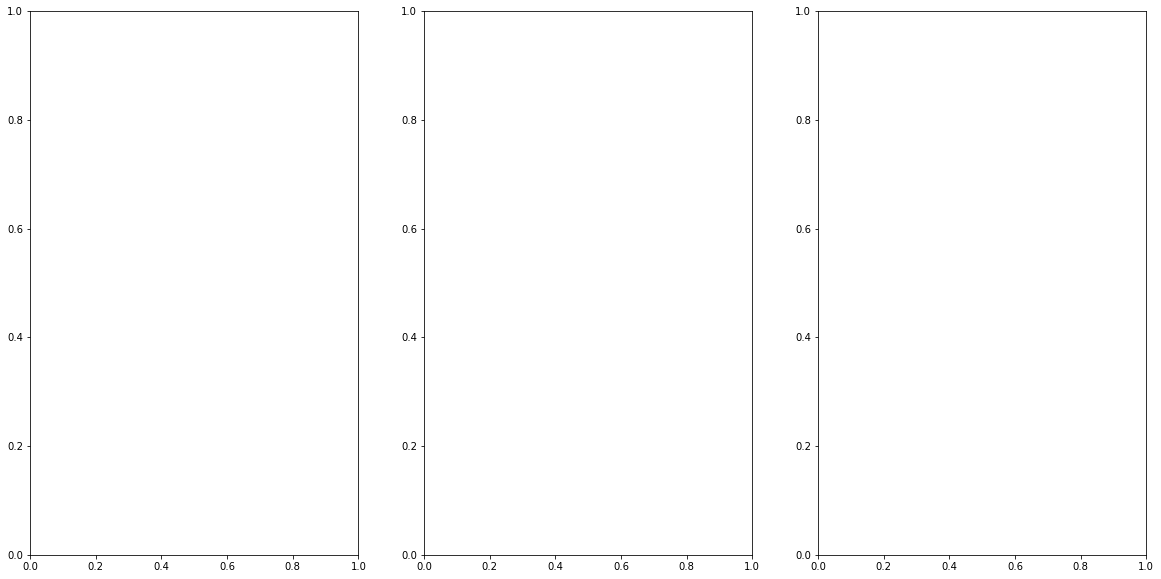

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
import pandas as pd

from scipy.ndimage import gaussian_filter

# loop through each flight pair and calculate rmse, r2, plot
lidar = None

# check if we are on borah or local
import socket
hn = socket.gethostname()
lidar_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar')
if hn == 'Zachs-MacBook-Pro.local':
    lidar_dir = Path('/Users/zachkeskinen/Desktop/')

# for lidar filepath
for lidar_fp in lidar_dir.glob('*.sd.nc'):
    print(lidar_fp)
    lidar = xr.open_dataset(lidar_fp)

    # single times are strings not lists
    if isinstance(lidar.attrs['lidar_times'] , str):
        lidar.attrs['lidar_times'] = [lidar.attrs['lidar_times']]

    for t in lidar.attrs['lidar_times']:

        t = pd.to_datetime(t)
        # slice images that occured that year
        ds = lidar.sel(time = slice(t - pd.Timedelta('180 days'), t))

        cum_sd232 = ds['232-sd_delta_int'].sum(dim = 'time').where(~ds['lidar-sd'].sel(time = t).isnull())
        cum_sd052 = ds['052-sd_delta_int'].sum(dim = 'time').where(~ds['lidar-sd'].sel(time = t).isnull())

        vmax = cum_sd232.sel(band = 'VV').quantile(0.9)

        if cum_sd052.sum() > 0:
            fig, axes = plt.subplots(1, 4, figsize = (20,10))
            data232 = cum_sd232.sel(band = 'VV')
            data232.data = gaussian_filter(data232, 3)
            data232.plot(vmin = 0, vmax = vmax, ax = axes[1], cmap = 'cividis')
            data = cum_sd052.sel(band = 'VV')
            data.data = gaussian_filter(data, 3)
            data.plot(vmin = 0, vmax = vmax, ax = axes[2], cmap = 'cividis')
            ax = axes[3]
        else:
            fig, axes = plt.subplots(1, 3, figsize = (20,10))
            data232 = cum_sd232.sel(band = 'VV')
            data232.data = gaussian_filter(data232, 3)
            data232.plot(vmin = 0, vmax = vmax, ax = axes[1], cmap = 'cividis')
            ax = axes[2]

        ds['lidar-sd'].sel(time = t).plot(vmin = 0, vmax = 3, ax = axes[0])

        xs = lidar['lidar-sd'].sel(time = t).values.ravel()
        ys = data232.values.ravel()

        xs_tmp = xs[(~np.isnan(xs)) & (~np.isnan(ys)) & (ys != 0)]
        ys = ys[(~np.isnan(xs)) & (~np.isnan(ys)) & (ys != 0)]
        xs = xs_tmp

        range = [[-.2, 5.5], [-.2, np.max(ys) + 0.3]]
        ax.hist2d(xs_tmp, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno, range = range)

        from scipy.stats import pearsonr
        r, p = pearsonr(xs, ys)
        ax.text(.01, .99, f'r: {r:.2}\nn = {len(ys):.2e}', ha = 'left', va = 'top', transform = ax.transAxes)
        plt.tight_layout()
        plt.show()
        # plt.savefig(f"/bsuhome/zacharykeskinen/uavsar-validation/figures/lidar/all/unw_{lidar.attrs['site']}_{t.strftime('%Y-%m-%d')}.png")

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
from tqdm import tqdm

from pathlib import Path
from stats import get_stats, clean_xs_ys

df = pd.read_csv('/Users/zachkeskinen/Documents/uavsar-validation/results/lidar-rs/inc.csv', index_col=['stat', 'loc','date'])

df.loc[('r')].T.rolling(3).mean().plot(figsize = (12,8))